In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor

df = pd.read_csv('stud_math.csv')

%matplotlib inline

In [2]:
# Отображение графика boxplot и countplot для анализа категориальных признаков
def boxplot_distr(column, small=False):

    if small:
        plt.figure(figsize=(3, 1))
    else:
        plt.figure(figsize=(9, 3))
    sns.boxplot(x=column, y='score', data=df)
    ax2 = plt.twinx()
    g = sns.countplot(x=column, data=df)
    for bar in g.patches:
        bar.set_width(0.05)
        x = bar.get_x()
        x -= 0.1
        bar.set_x(x)
    plt.show()
    plt.close()

In [74]:
def get_stat_dif(cacao, column):
    cols = cacao.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(cacao.loc[cacao.loc[:, column] == comb[0], 'score'],
            cacao.loc[cacao.loc[:, column] == comb[1], 'score']).pvalue \
                <= 0.05/len(combinations_all):  # Учли поправку Бонферрони
            print('Найдены статистически значимые различия для колонки',
                  column)
            break

## Часть первая. Ознакомительная


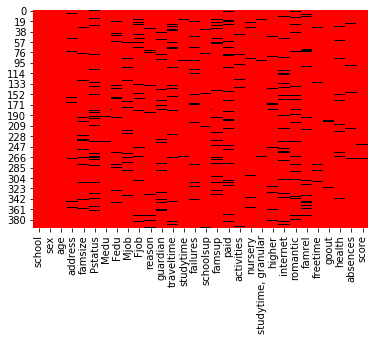

In [96]:
# Начнем с пропусков
# определяем цвета
# черный - пропущенные данные, красный - не пропущенные
colours = ['#FF0000', '#000000'] 
sns.heatmap(df.isnull(), cbar=False, cmap=sns.color_palette(colours))

In [5]:
print(f'There are {len(df.dropna())} rows in dataset without missing values \
of {len(df)} total rows')
print(f'There are {df.isnull().any().sum()} columns in dataset with missing \
values.')
print(f'{df.shape[0]} samples and {df.shape[1]} features in the dataset.')

There are 97 rows in dataset without missing values of 395 total rows
There are 27 columns in dataset with missing values.
395 samples and 30 features in the dataset.


*Пропуски разбросаны по датафрейму, простое удаление строк с пропусками  
приводит к потере около 3/4 всех данных. Необходима работа с пропусками.*

In [6]:
# найдем количество пропусков в строках датасета и сгруппируем их.
df.apply(lambda x: pd.isna(x).sum(), axis=1).value_counts()

1    131
2     98
0     97
3     47
4     15
5      5
6      2
dtype: int64

*Строчек в датесете содержащих значительное количество  пропусков  
(хотя бы более половины) не найдено, по этому критерию очистка невозможна.*

*Поскольку уникальных значений в датасете не так много, просто выведем их  
количество для каждого столбца. Это позволит сразу  оценить и количество  
пропусков и явные выбросы.*

In [7]:
for feature in df.columns:
    print(df[feature].value_counts(dropna=False))

GP    349
MS     46
Name: school, dtype: int64
F    208
M    187
Name: sex, dtype: int64
16    104
17     98
18     82
15     82
19     24
20      3
22      1
21      1
Name: age, dtype: int64
U      295
R       83
NaN     17
Name: address, dtype: int64
GT3    261
LE3    107
NaN     27
Name: famsize, dtype: int64
T      314
NaN     45
A       36
Name: Pstatus, dtype: int64
4.0    131
2.0    102
3.0     97
1.0     59
0.0      3
NaN      3
Name: Medu, dtype: int64
2.0     106
3.0      96
4.0      88
1.0      78
NaN      24
0.0       2
40.0      1
Name: Fedu, dtype: int64
other       133
services     98
at_home      58
teacher      55
health       32
NaN          19
Name: Mjob, dtype: int64
other       197
services    102
NaN          36
teacher      29
at_home      16
health       15
Name: Fjob, dtype: int64
course        137
home          104
reputation    103
other          34
NaN            17
Name: reason, dtype: int64
mother    250
father     86
NaN        31
other      28
Name: gua

Посмотрим на корреляцию числовых признаков в наших данныьх:

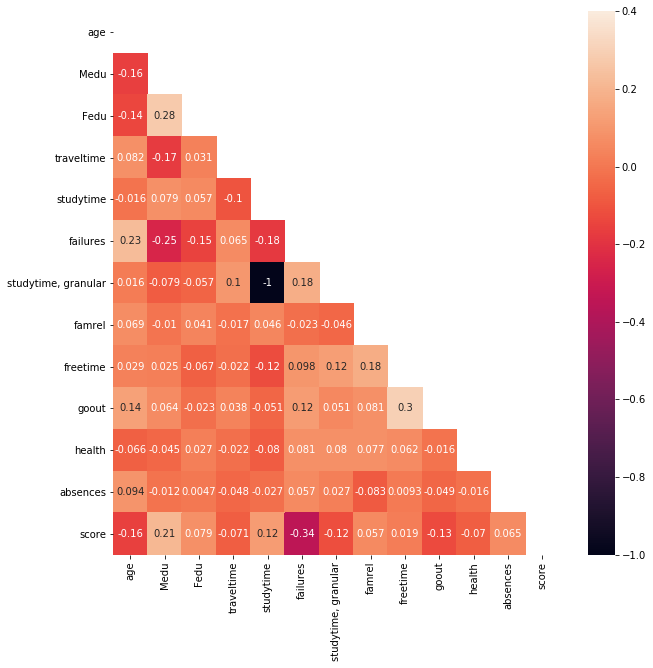

In [8]:
fig, ax = plt.subplots(figsize=(10, 10))
corr = df.corr()
matrix = np.triu(corr)
sns.heatmap(corr, annot=True,  fmt='.2g', mask=matrix,
            vmin=-1, vmax=0.4)

*Бросается в глаза 100 процентная корреляция между **'studytime, granular'**  
и **'studytime'**. Пасхалка от составителя задания найдена. Столбец  
**'studytime, granular'**  удалим.*

In [9]:
df.drop('studytime, granular', axis=1, inplace=True)

*Проанализируем целевую переменную **'score'**. Мои выводы по ней приводят к  
редактированию всего датасета, поэтому сделаем это сразу.*

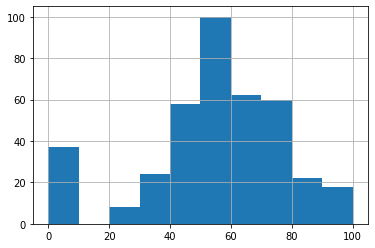

In [10]:
df.score.hist()

Видим две части: на правой распределение очень похожее на нормальное, левая  
содержит значение 0. При стобальной оценке на экзамене, оценка 0 скорее значит,  
что ученик не писал работу совсем, либо оценка не попала в данные.

In [11]:
df[df.score == 0][['absences', 'score']].head()

,absences,score
128,0.0,0.0
130,0.0,0.0
131,0.0,0.0
134,0.0,0.0
135,0.0,0.0


*Здесь вывод ограничен пятью строками для удобства чтения, но на всех остальных  
данных поле 'absences' также содержит нулевое значение (и один NaN) при нулевом  
'score'. Источник данных о пропущенных занятиях и итоговая оценка это школа,  
остальные данные могли быть получены из других источников, здесь явно какая-то  
аномалия. Причем нулевая оценка по экзамену никак не коррелирует с другими  
данными, например  вряд ли выглядит правдоподобным желание получить высшее  
образование и нулевая оценка по математике. Мне кажется более правильным удалить  
строки с нулевым значением 'score',  чем заменять эти значения, например на среднее  
или обучать модель на нулевых значениях. По тем же соображениям удалим строки (6)  
с пропусками в целевой переменной.*

In [12]:
df = df[df.score != 0]
df = df.dropna(subset=['score'])

In [13]:
# Разделим колонки по типам переменных, содержащихся в них.
cat_cols = df.columns[df.dtypes == 'O'].to_list()
num_cols_y = df.columns[df.dtypes != 'O'].to_list()
num_cols = df.columns[df.dtypes != 'O'].to_list()
num_cols.remove('score')

## Часть вторая.  Категориальная

*Из всех признаков датасета, выраженных числами, чисто числовым является  
только absences, остальные подходят под определение порядковых и скорее  
относятся к категориальным переменным*

In [14]:
# Отберем категориальные признаки в которых есть значение 'other'
cat_cols_not_binary = []
for it in cat_cols:
    if 'other' in df[it].values:
        cat_cols_not_binary.append(it)
cat_cols_binary = list(set(cat_cols) - set(cat_cols_not_binary))

*Для этих признаков заменим **пропуски** значением **'other'** как наиболее подходящее по  
смыслу. 

In [15]:
df[cat_cols_not_binary] = df[cat_cols_not_binary].fillna('other')

Признак **Mjob**

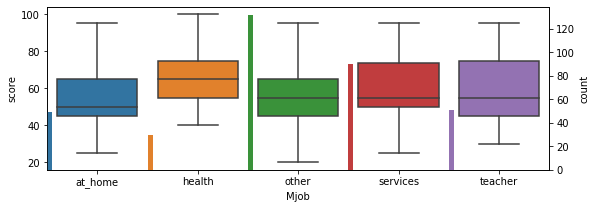

In [16]:
boxplot_distr('Mjob')

Признак выглядит влияющим на целевую переменную.

Признак **Fjob**

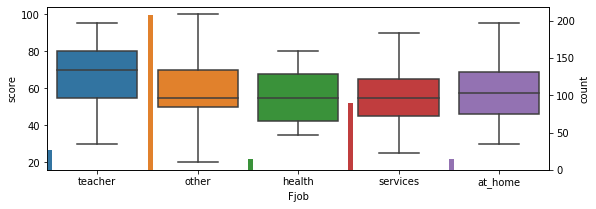

In [17]:
boxplot_distr('Fjob')

Признак выглядит влияющим на целевую переменную. 

Признак **reason**

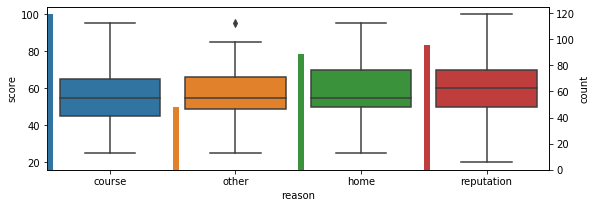

In [18]:
boxplot_distr('reason')

Признак выглядит слабо влияющим на целевую переменную. 

Признак **guardian**

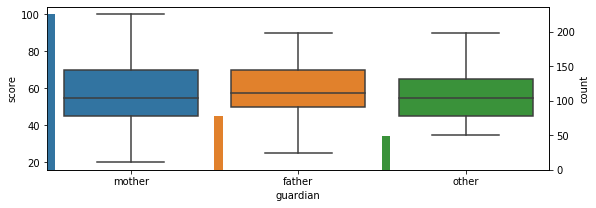

In [19]:
boxplot_distr('guardian')

Признак выглядит слабо влияющим на целевую переменную. 

In [20]:
ord_cols = ['Medu', 'Fedu', 'traveltime', 'studytime', 'famrel', 'freetime',
            'goout', 'health', 'failures', 'age']

### Категориальные порядковые признаки

### Fedu, Medu

Значение в Fedu 40 явный выброс, скорее всего приписан лишний "0", заменим на 4.

In [21]:
df.loc[df.Fedu == 40, 'Fedu'] = 4.0

In [22]:
df.groupby('Fedu').Medu.value_counts()

Fedu  Medu
0.0   1.0      1
      4.0      1
1.0   1.0     28
      2.0     22
      3.0     13
      0.0      1
2.0   2.0     41
      3.0     22
      4.0     18
      1.0     11
      0.0      2
3.0   4.0     37
      3.0     32
      2.0     15
      1.0      4
4.0   4.0     59
      3.0     14
      2.0      7
      1.0      1
Name: Medu, dtype: int64

Наблюдается взаимосвязь между переменными Medu и Fedu, для каждого значения Fedu  
самое частое значение Medu совпадают или находится на втором месте. Поэтому  для  
заполнения пропусков (24) в Fedu присвоим значение Medu из этой же строчки. Наоборот  
поступим также, там аналогичная зависимость без исключений.

In [23]:
df.Fedu = df.Fedu.fillna(df.Medu)
df.Medu = df.Medu.fillna(df.Fedu)

Признак выглядит производящим влияние на целевую переменную.

In [24]:
df.Fedu.value_counts()

2.0    97
3.0    95
4.0    91
1.0    67
0.0     2
Name: Fedu, dtype: int64

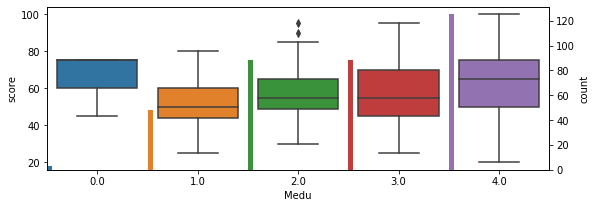

In [25]:
boxplot_distr('Medu')

Первая категория содержит мало значений, но целом видится влияние на целевую  
переменную.

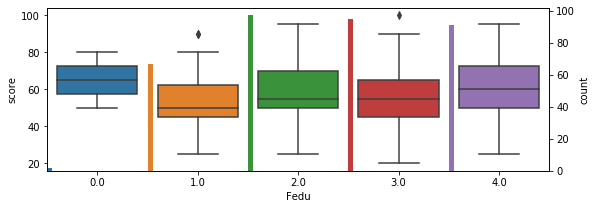

In [26]:
boxplot_distr('Fedu')

Более-менее равномерное распределение по категориям, есть небольшое влияние на  
целевую  переменную.

### Traveltime

Выбросов нет, 28 пропусков.

In [27]:
df.groupby(['school', 'address']).traveltime.value_counts(dropna=False)

school  address  traveltime
GP      R        1.0            28
                 2.0            15
                 3.0             4
                 NaN             3
                 4.0             3
        U        1.0           173
                 2.0            50
                 NaN            15
                 3.0             7
                 4.0             3
MS      R        2.0             7
                 3.0             6
                 1.0             4
                 NaN             2
                 4.0             1
        U        2.0             9
                 1.0             8
Name: traveltime, dtype: int64

Школьники из школы GP независимо от типа адреса чаще всего добираются за время  
менее 15 минут, а из MS за промежуток 15-30 минут. Заполним пропуски по этому  
принципу.

In [28]:
df['traveltime'] = df.apply(lambda x: (1.0 if x.school == 'GP' else 2.0)
                            if pd.isna(x.traveltime) else x.traveltime, axis=1)

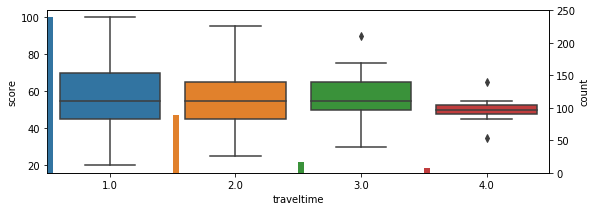

In [29]:
boxplot_distr('traveltime')

По мере уменьшения количества значений в каждой категории разброс сжимается  
вдоль одной оси, выглядит слабовлияющим.

### Studytime
Выбросов нет, 7 пропусков.

In [30]:
df.groupby('freetime').studytime.value_counts(dropna=False)

freetime  studytime
1.0       2.0           8
          4.0           3
          1.0           2
          3.0           2
          NaN           1
2.0       2.0          27
          1.0          18
          3.0           9
          4.0           5
3.0       2.0          66
          1.0          28
          3.0          26
          4.0          10
          NaN           2
4.0       2.0          55
          1.0          25
          3.0          19
          4.0           2
          NaN           1
5.0       1.0          16
          2.0          13
          4.0           3
          NaN           2
          3.0           1
Name: studytime, dtype: int64

*Если у ученика много свободного времени после школы, значит он мало занимается  
после школы. Данные это предположение не отвергают, поэтому заполним  
**studytime** 1.0, если **freetime** равно 5.0, и значением 2.0 в остальных случаях.*

In [31]:
df['studytime'] = df.apply(lambda x: (1.0 if x.freetime == 5.0 else 2.0)
                           if pd.isna(x.studytime) else x.studytime, axis=1)

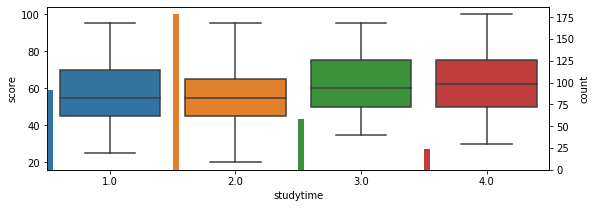

In [32]:
boxplot_distr('studytime')

Если зависимость и есть, то небольшая.

### Famrel
Один выброс - отрицательное значение "-1", просто поменяем ему знак. Пропусков - 27,  
заполним самым популярным значением этого поля 4.0

In [33]:
df.loc[df.famrel == -1, 'famrel'] = 1
df.famrel.fillna(4.0, inplace=True)

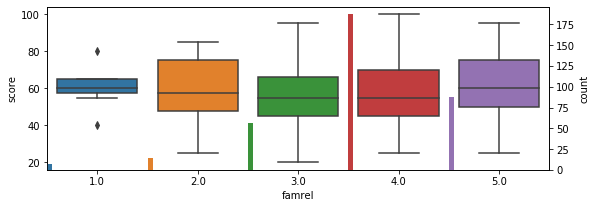

In [34]:
boxplot_distr('famrel')

Среднее значение примерно на одной уровне, разброс увеличивается при  увеличении  
количества значений. Влияние не выглядит сильным.

### Health
Выбросов нет. Пропусков - 15, заполним самым популярным значением этого поля 5.0

In [35]:
df.health.fillna(5.0, inplace=True)

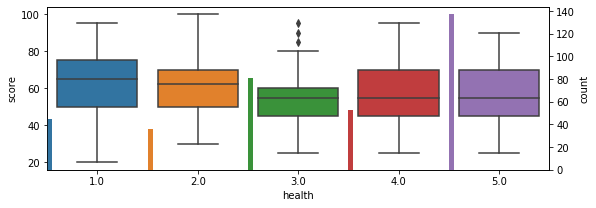

In [36]:
boxplot_distr('health')

Категории выглядят одинаково, какой-то закономерности не прослеживается.

### Freetime

Выбросов нет. Пропусков - 11. 3.0 - самое частое значение, середина нашей  шкалы  
по этой колонке , поэтому заполним пропуск "золотой" серединой.

In [37]:
df.freetime.fillna(3.0, inplace=True)

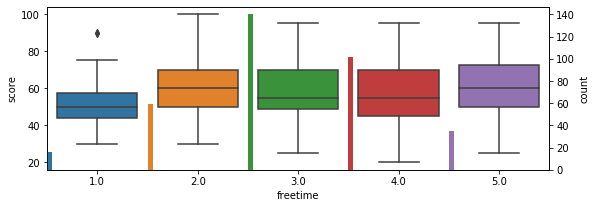

In [38]:
boxplot_distr('freetime')

Аналогично предыдущему пункту визуально зависимости не видно, распределение  
похоже на нормальное, что встречается редко в этом датасете.

Признак **age**

Пропусков нет, выбросов тоже.

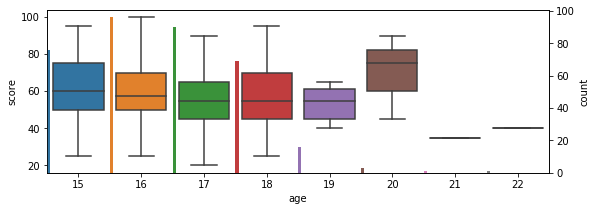

In [39]:
boxplot_distr('age')

Правая часть графика имеет отличия, но там слишком мало значений для выводов.  
Не влияет.

### Failures

Выбросов нет. Пропусков - 22. Здесь нулевое значение побеждает с большим отрывом,  
поэтому заполним пропуск им

In [40]:
df.failures.fillna(0, inplace=True)

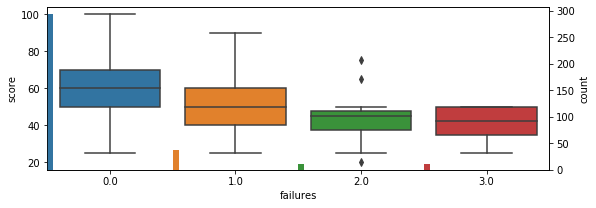

In [41]:
boxplot_distr('failures')

Прослеживается снижение снижение score от роста failrues, смущает сильная  
неравномерность по категориям.

### Goout

Выбросов нет. Пропусков - 8. 

In [42]:
df.goout.fillna(3.0, inplace=True)

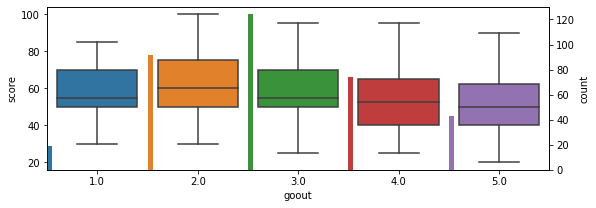

In [43]:
boxplot_distr('goout')

Распределение по категориям похоже на нормальное, небольшая разница заметна.

 ## Категориальные признаки с двумя значениями

Для бинарных признаков пропуски заменим на более частое значение этого  
признака, кроме признака address

Признак **school**

*Пропусков в данных нет. В датасете содержатся данные об учениках только двух  
школ. Поиск не дал результатов, что по этим аббревиатурам можно  
категоризировать школу (например государственная, муниципальная или частная).* 

Признак **address**

In [44]:
df.groupby('address').traveltime.value_counts()

address  traveltime
R        1.0            35
         2.0            24
         3.0            10
         4.0             4
U        1.0           196
         2.0            59
         3.0             7
         4.0             3
Name: traveltime, dtype: int64

Если traveltime равно 1, ставим адрес = U, в других случаях R.

In [45]:
df['address'] = df.apply(lambda x: ('U' if x.traveltime == 1 else 'R')
                         if pd.isna(x.address) else x.address, axis=1)

In [46]:
# Заполняем пропуски самым частым значением.
for it in cat_cols_binary:
    df[it].fillna(df[it].value_counts().idxmax(), inplace=True)

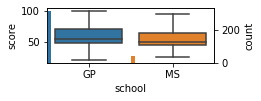

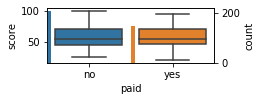

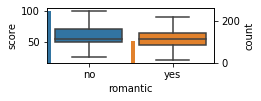

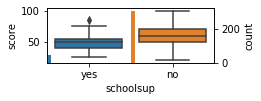

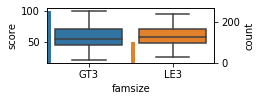

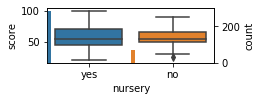

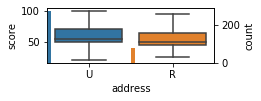

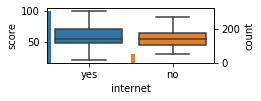

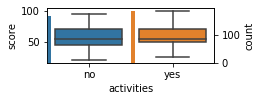

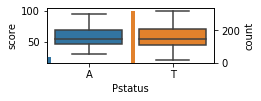

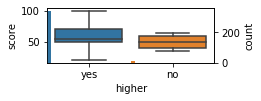

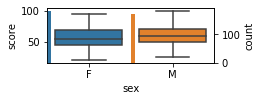

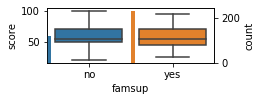

In [47]:
for col in cat_cols_binary:
    boxplot_distr(col, small=True)

Графики довольно одинаковы, выделяется только schoolsup, остальные признаки  
выглядят мало влияющим на целевую переменную.

In [ ]:
Посмотрим на наши переменные статистическим методом:

In [67]:
#Признак age исключен, т.к. выдает кучу предупреждений. Видимо из-за единичных
#значений в категориях 22 и 21 год
for col in cat_cols+ord_cols[:-1]:
    get_stat_dif(df, col)

Найдены статистически значимые различия для колонки address
Найдены статистически значимые различия для колонки Mjob
Найдены статистически значимые различия для колонки Fjob
Найдены статистически значимые различия для колонки schoolsup
Найдены статистически значимые различия для колонки Medu
Найдены статистически значимые различия для колонки Fedu
Найдены статистически значимые различия для колонки studytime
Найдены статистически значимые различия для колонки goout
Найдены статистически значимые различия для колонки failures


*По совету коллег с ODS для оценки категориальных переменных построим Random Forest  
на всех этих переменных и посмотрим features importance.* 

**Спойлер: ничего не получилось**

In [54]:
df_cat = df[cat_cols]
X_enc = OrdinalEncoder().fit_transform(df_cat[cat_cols])
X_train, X_test, y_train, y_test = train_test_split(X_enc,
            df.loc[:, 'score'], test_size=0.25, random_state=42)
d_train = lgb.Dataset(X_train, label=y_train,
                      categorical_feature=list(range(0, 17)))
# specify your configurations as a dict
params = {
    'boosting_type': 'rf',
    'feature_fraction': 0.3,
    'bagging_fraction': 0.5,
    'fraction_freq': 1,
    'bagging_freq': 1
}
gbm = lgb.train(params, d_train, categorical_feature=list(range(0, 17)))
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)

The rmse of prediction is: 16.28715930376997


In [55]:
for it in zip(cat_cols, gbm.feature_importance()):
    print(it[0], ':', it[1])

school : 2
sex : 33
address : 23
famsize : 18
Pstatus : 0
Mjob : 0
Fjob : 0
reason : 57
guardian : 32
schoolsup : 12
famsup : 27
paid : 26
activities : 38
nursery : 5
higher : 0
internet : 10
romantic : 17


Получилось все очень печально. На этих данных модель хорошо обучится не смогла,  
выдает результат на уровне простого среднего значения. Оценку по этому способу  
дать невозможно.

## Часть третья.  Числовая


Остался всего один признак, более похожий на числовой, чем все остальные признаки.

### Absences
Колонка с пропусками занятий absences содержит два выброса - 385 и 212. Для  
пропущенных занятий это слишком большое значение.
Заменим на среднее значение без  
учета этих выбросов, дробную часть отбросим.  Пропуски заменим тем же средним.

In [56]:
df[df.absences > 100].absences

222    385.0
390    212.0
Name: absences, dtype: float64

In [57]:
mean_ab = int(df.absences[df.absences < 100].mean())
index = df.absences[df.absences > 100].index
df.loc[index, 'absences'] = mean_ab
df.absences.fillna(mean_ab, inplace=True)

Из матрицы коррелляций берем значение для нашего признака: **0,065**  
Значение слишком мало, чтобы сделать вывод о наличии корреляции между этим признаком  
и целевой переменной.

Попробуем очищенный датасет "скормить" модели из "вкусной и здровой пищи"

In [68]:
df[cat_cols] = OrdinalEncoder().fit_transform(df_cat[cat_cols])
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, :-1],
    df.loc[:, 'score'], test_size=0.25, random_state=42)
# Создаём модель
regr = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

In [69]:
print('MAE:', mean_absolute_error(y_test, y_pred))

MAE: 11.326704545454545


Результат очень плохой, но если бы получилось построить хорошую модель, то   
можно было бы отобрать признаки используемые моделью.

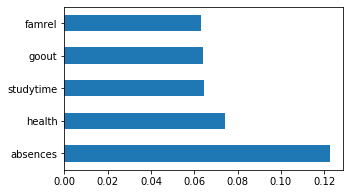

In [73]:
#в RandomForestRegressor есть возможность вывести самые важные признаки
plt.rcParams['figure.figsize'] = (5, 3)
feat_importances = pd.Series(
    regr.feature_importances_, index=df.iloc[:, :-1].columns)
feat_importances.nlargest(5).plot(kind='barh')

### Наш итоговый очищенный датасет:

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 352 entries, 0 to 394
Data columns (total 29 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   school      352 non-null    float64
 1   sex         352 non-null    float64
 2   age         352 non-null    int64  
 3   address     352 non-null    float64
 4   famsize     352 non-null    float64
 5   Pstatus     352 non-null    float64
 6   Medu        352 non-null    float64
 7   Fedu        352 non-null    float64
 8   Mjob        352 non-null    float64
 9   Fjob        352 non-null    float64
 10  reason      352 non-null    float64
 11  guardian    352 non-null    float64
 12  traveltime  352 non-null    float64
 13  studytime   352 non-null    float64
 14  failures    352 non-null    float64
 15  schoolsup   352 non-null    float64
 16  famsup      352 non-null    float64
 17  paid        352 non-null    float64
 18  activities  352 non-null    float64
 19  nursery     352 non-null    f

## Выводы:

1. В данных содержится большое количество пропусков. Странное совпадение нулевых значений в колоноках 'absences' и 'score', которое логически не связывается с остальными данными. Можно попробовать выяснить причину, возможны какие-то ошибки при формировании данных.
2. Признак 'school'. Если это аббревиатуры двух конкретных школ, а предскзания будут делаться для учеников из других школ этот признак бесполезен.
3. Категориальные переменные: по "ящикам с усами" визуально видится влияние переменных Mjob, Fjob, Fedu, Medu, failures, goout, schoolsup. 
4. Статистическим методом найдены различия: address, Mjob, Fjob, Medu, Fedu, studytime, failures, goout, schoolsup.
5. Признак absences имеет слабую корреляцию с целевой переменной.
6. Признаки рекомендуемые для построения модели: address, Mjob, Fjob, Medu, Fedu, studytime, failures, goout, schoolsup.